# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

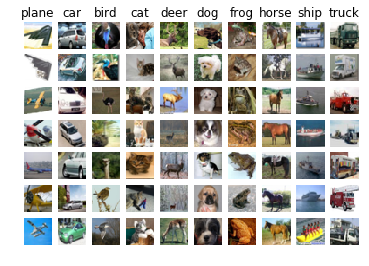

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1        
        #Create a grid of samples with the following structure
        #samples_per_class rows
        #num_classes column
        #Subplot index
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
#Genera campioni tra 0 e 48000 a passo di 1
mask = range(num_training)
#Prendi le prime 48000 immagini e le rispettive label
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
# genero 500 campioni distribuiti in maniera uniforme presi da num_training
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [8]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64297917  135.92841667  132.4100625   130.0744375   135.3130625
  131.70479167  131.0373125   136.18741667  132.48804167  131.65420833]


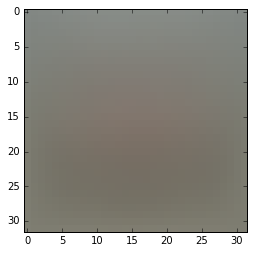

In [9]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data. It calculates the mean of the first pixel of the
# red images, then calculates the mean of the second pixel of the red images and so on. This is repeated
# for blue and green images.
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
# Reshape of the previous vector of 3072 into three matrix 32x32. Matrix of means.
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [10]:
# second part of preprocessing: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
# for any info https://hetpinvn.wordpress.com/2016/10/26/bias-trick/ 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropoy_loss_naive` function.

Running this method might take a while...

In [12]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073,10) * 0.01
print(W)

loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

[[-0.00268238 -0.00861994  0.00884871 ..., -0.01296095  0.01448747
   0.00131181]
 [-0.00289106  0.00463282 -0.01117418 ...,  0.00372753 -0.00321971
  -0.02011133]
 [-0.01536884  0.01512815  0.00522983 ..., -0.0037133   0.00522404
   0.00726859]
 ..., 
 [ 0.00695581  0.01056475  0.01866191 ...,  0.00647584  0.00129849
  -0.00213753]
 [-0.00109207  0.00243852  0.0101581  ..., -0.00082907 -0.00301944
   0.01268476]
 [-0.00256307  0.01099659 -0.00585991 ..., -0.00823526  0.0025542
   0.00677041]]
loss: 44.516245
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)?  
    
    <b>Answer:</b> The reason is related to the value of the weights. They are random so we are making a random choice at the beginning. So our loss must be close to the probability to pick the right value which is 1/10.</p>
</div>

Complete the implementation of the `cross_entropoy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [13]:
from exercise_code.gradient_check import grad_check_sparse

loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropoy_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 2.7388277416662272 analytic: 2.738827740480702, relative error: 2.1642927624004644e-10
numerical: 0.3967265111981532 analytic: 0.39672651248191826, relative error: 1.617947125292272e-09
numerical: 4.575344542345761 analytic: 4.575344535782984, relative error: 7.171893758474047e-10
numerical: -0.5944836473759096 analytic: -0.5944836386155573, relative error: 7.368034794273071e-09
numerical: -0.30448152728013156 analytic: -0.30448154162209995, relative error: 2.355145841032413e-08
numerical: 3.2196726095889967 analytic: 3.2196726083006584, relative error: 2.000728771820751e-10


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropoy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [14]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_vectorized

tic = time.time()
loss_naive, grad_naive = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 4.451626e+01 computed in 0.118881s
vectorized loss: 4.451626e+01 computed in 0.063580s
Loss difference: 0.000000
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
    <p>**Your answer:** Since $\exp(x + c) = \exp(x)\exp(c)$, one can add the same constant to each exponential, which then cancels when forming the softmax quotient. If we substract the maximum of all scores (a differnt constant for each sample in the minibatch!), then we won't sum too large numbers. 
</p>
</div>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [15]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train,learning_rate=1e-7,reg=5e4,num_iters=1500,batch_size=200,verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 773.021952
iteration 100 / 1500: loss 283.745220
iteration 200 / 1500: loss 105.111560
iteration 300 / 1500: loss 39.790090
iteration 400 / 1500: loss 15.865589
iteration 500 / 1500: loss 7.135727
iteration 600 / 1500: loss 3.964700
iteration 700 / 1500: loss 2.745625
iteration 800 / 1500: loss 2.311881
iteration 900 / 1500: loss 2.137665
iteration 1000 / 1500: loss 2.111756
iteration 1100 / 1500: loss 2.057636
iteration 1200 / 1500: loss 2.081429
iteration 1300 / 1500: loss 2.012420
iteration 1400 / 1500: loss 2.072612
That took 32.771481s


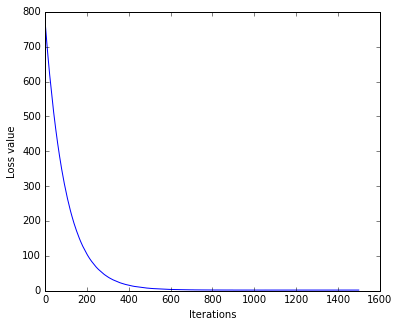

In [16]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [17]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.330271
validation accuracy: 0.326000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [19]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
all_classifiers = []
# ATTENTION! These value are hyperparameters. They were picked in a random way.
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a classifier on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       # 
# once you are confident that your validation code works, you should rerun     #
# the validation code with a larger value for num_iters.                       #
################################################################################


for i in range(len(learning_rates)):
    learning_i=learning_rates[i]
    for k in range(len(regularization_strengths)):
        reg_k=regularization_strengths[k]
        # The SoftmaxClassifier class inherits from LinearClassifier
        softmax = SoftmaxClassifier()
        loss_hist = softmax.train(X_train, y_train,learning_i,reg_k,num_iters=1500,batch_size=200,verbose=True)
        # We let our softmax to make a predition on two different datasets
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        #Just two temporary variable
        tuple1=(learning_i,reg_k)
        tuple2=(train_accuracy,validation_accuracy)
        results[tuple1]=tuple2;
        #If we find a better accuracy this become our now best_val
        if (validation_accuracy > best_val):
            best_val = validation_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for (lr, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1500: loss 5.013867
iteration 100 / 1500: loss 5.427958
iteration 200 / 1500: loss 4.979916
iteration 300 / 1500: loss 4.589959
iteration 400 / 1500: loss 4.209368
iteration 500 / 1500: loss 4.331670
iteration 600 / 1500: loss 3.920400
iteration 700 / 1500: loss 4.285446
iteration 800 / 1500: loss 4.013285
iteration 900 / 1500: loss 4.260843
iteration 1000 / 1500: loss 3.428830
iteration 1100 / 1500: loss 3.788305
iteration 1200 / 1500: loss 3.630796
iteration 1300 / 1500: loss 3.538239
iteration 1400 / 1500: loss 3.804171
iteration 0 / 1500: loss 5.680820
iteration 100 / 1500: loss 5.271028
iteration 200 / 1500: loss 4.984440
iteration 300 / 1500: loss 5.241191
iteration 400 / 1500: loss 4.484286
iteration 500 / 1500: loss 4.594012
iteration 600 / 1500: loss 4.723851
iteration 700 / 1500: loss 4.190730
iteration 800 / 1500: loss 4.161119
iteration 900 / 1500: loss 4.075272
iteration 1000 / 1500: loss 3.883950
iteration 1100 / 1500: loss 4.021790
iteration 1200 / 1500: lo

iteration 100 / 1500: loss 6.546061
iteration 200 / 1500: loss 5.578007
iteration 300 / 1500: loss 5.209955
iteration 400 / 1500: loss 5.328203
iteration 500 / 1500: loss 5.529519
iteration 600 / 1500: loss 5.231487
iteration 700 / 1500: loss 4.693209
iteration 800 / 1500: loss 4.583861
iteration 900 / 1500: loss 4.730831
iteration 1000 / 1500: loss 4.464969
iteration 1100 / 1500: loss 4.404112
iteration 1200 / 1500: loss 4.336748
iteration 1300 / 1500: loss 4.561684
iteration 1400 / 1500: loss 4.366093
iteration 0 / 1500: loss 20.801789
iteration 100 / 1500: loss 19.430114
iteration 200 / 1500: loss 18.606701
iteration 300 / 1500: loss 18.469790
iteration 400 / 1500: loss 18.101933
iteration 500 / 1500: loss 17.790782
iteration 600 / 1500: loss 17.649153
iteration 700 / 1500: loss 17.081759
iteration 800 / 1500: loss 17.086281
iteration 900 / 1500: loss 16.770858
iteration 1000 / 1500: loss 16.454358
iteration 1100 / 1500: loss 16.482295
iteration 1200 / 1500: loss 16.466243
iteration

iteration 100 / 1500: loss 2.990460
iteration 200 / 1500: loss 2.645102
iteration 300 / 1500: loss 2.723624
iteration 400 / 1500: loss 2.276941
iteration 500 / 1500: loss 2.248359
iteration 600 / 1500: loss 2.238673
iteration 700 / 1500: loss 2.185486
iteration 800 / 1500: loss 2.162135
iteration 900 / 1500: loss 2.432401
iteration 1000 / 1500: loss 2.032156
iteration 1100 / 1500: loss 2.079740
iteration 1200 / 1500: loss 2.082960
iteration 1300 / 1500: loss 2.101339
iteration 1400 / 1500: loss 2.139338
iteration 0 / 1500: loss 5.246504
iteration 100 / 1500: loss 3.488490
iteration 200 / 1500: loss 2.787531
iteration 300 / 1500: loss 2.335867
iteration 400 / 1500: loss 2.594824
iteration 500 / 1500: loss 2.452078
iteration 600 / 1500: loss 2.548277
iteration 700 / 1500: loss 2.284572
iteration 800 / 1500: loss 2.328151
iteration 900 / 1500: loss 2.084773
iteration 1000 / 1500: loss 2.290952
iteration 1100 / 1500: loss 2.360304
iteration 1200 / 1500: loss 2.261460
iteration 1300 / 1500:

iteration 200 / 1500: loss 2.037218
iteration 300 / 1500: loss 2.121148
iteration 400 / 1500: loss 2.032465
iteration 500 / 1500: loss 2.040549
iteration 600 / 1500: loss 1.861285
iteration 700 / 1500: loss 1.979982
iteration 800 / 1500: loss 1.938810
iteration 900 / 1500: loss 1.786686
iteration 1000 / 1500: loss 1.910726
iteration 1100 / 1500: loss 1.743975
iteration 1200 / 1500: loss 1.809885
iteration 1300 / 1500: loss 1.820579
iteration 1400 / 1500: loss 1.699125
iteration 0 / 1500: loss 5.275533
iteration 100 / 1500: loss 2.451205
iteration 200 / 1500: loss 1.954273
iteration 300 / 1500: loss 2.077814
iteration 400 / 1500: loss 2.152997
iteration 500 / 1500: loss 2.180523
iteration 600 / 1500: loss 1.882047
iteration 700 / 1500: loss 2.036361
iteration 800 / 1500: loss 2.027672
iteration 900 / 1500: loss 1.776590
iteration 1000 / 1500: loss 1.892548
iteration 1100 / 1500: loss 1.824282
iteration 1200 / 1500: loss 1.946077
iteration 1300 / 1500: loss 1.682886
iteration 1400 / 1500

iteration 400 / 1500: loss 3.568715
iteration 500 / 1500: loss 3.443218
iteration 600 / 1500: loss 2.885349
iteration 700 / 1500: loss 3.056896
iteration 800 / 1500: loss 4.278368
iteration 900 / 1500: loss 3.072975
iteration 1000 / 1500: loss 3.513354
iteration 1100 / 1500: loss 2.469687
iteration 1200 / 1500: loss 3.700071
iteration 1300 / 1500: loss 2.901534
iteration 1400 / 1500: loss 2.679694
iteration 0 / 1500: loss 22.271993
iteration 100 / 1500: loss 4.983672
iteration 200 / 1500: loss 4.597514
iteration 300 / 1500: loss 3.671959
iteration 400 / 1500: loss 3.128979
iteration 500 / 1500: loss 4.063565
iteration 600 / 1500: loss 3.052476
iteration 700 / 1500: loss 3.458199
iteration 800 / 1500: loss 2.941881
iteration 900 / 1500: loss 2.802252
iteration 1000 / 1500: loss 3.370796
iteration 1100 / 1500: loss 3.515152
iteration 1200 / 1500: loss 3.809891
iteration 1300 / 1500: loss 3.269005
iteration 1400 / 1500: loss 2.397448
iteration 0 / 1500: loss 161.570179
iteration 100 / 150

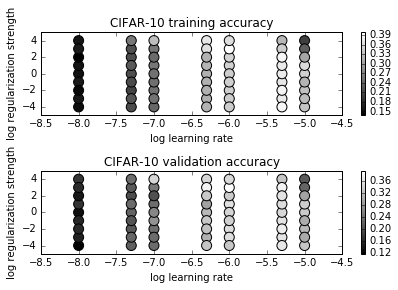

In [20]:
# Visualize the validation results in a logarithm scale
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [21]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(results, key=lambda x : x[1])
best_softmax2 = sorted_classifiers[-1][0]
print(best_softmax2)

1e-06


In [22]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.405000


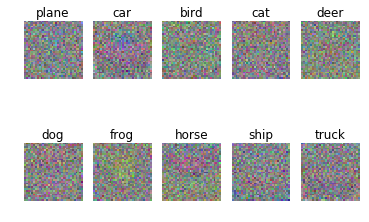

In [23]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like. Some of the weights remind us to some classes. For example car. However the weight are BAD(noisy) due to the not so good training.</p>
</div>

## Save the model

When you are satisfied with your training, save the model for submission.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [24]:
from exercise_code.model_savers import save_softmax_classifier
from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)